# Classification on MNIST
This notebook includes my notes and exploration of different classifiers on MNIST dataset. 

## Data Prepration
first thing to do, we downlaod the mnist dataset from sklearn datasets. We also need to know what kind of data we are dealing with and answer questions like how many samples do we have, what is the shape of each sample , etc.

In [1]:
from sklearn.datasets.base import get_data_home 
print (get_data_home())

/home/aramhamidi/scikit_learn_data


In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [3]:
mnist     

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

As we can see in the description, data is containing one row per instance and one column per feature.

In [4]:
x,y = mnist['data'],mnist['target']
print(x.shape)
print(y.shape)

(70000, 784)
(70000,)


number of images are 70000 and we have 784 features per sample. 784 is coming from the fact that images are 28 by 28 pixels and each pixel counts as a feature. Now let's look at some of those sample images.

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

label of this image is  3.0


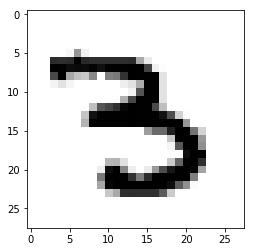

In [6]:
picked_sample = x[22000]
picked_sample_image = picked_sample.reshape(28,28)
print('label of this image is ',y[22000])
plt.imshow(picked_sample_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.show()

### Train, Test and Validation sets
mnist dataset is already splited in to training set, which is the first 60000 images, and also test set whih is the last 10000 images. However we need to shuffle the training set to garantee that our training dataset is random enough.

In [7]:
x_train, y_train, x_test, y_test = x[:60000], y[:60000], x[60000:], y[60000:]

In [8]:
import numpy as np
shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier
Binary classifiers like SVM or Linear classifiers can only distinguish between two classes. Some of the algorithms like naive Bayes classifiers or Random Forest classifiers can handle multiple classes directly. 
This is the first classifier, we are going to explor. Binary classifier in this case can detec one digit among the others. It acts like a Buzzer, whenever it finds a *'3'* for example, it Buzzez that it found one. Of course if it trains well. Otherwise it won't be able to find any.
## Stochastic Gradient Descent Classifier

In [9]:
# In our binary classifier we only care about two kind of labels: 1 (for digits == 3 and 0 (for digits != 3)
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3) 

Since our dataset is fairly large, let's use SGD classierfier. SGD classifiers are also very efficient for online training.

In [10]:
from sklearn.linear_model import SGDClassifier
# since we want some reproducable results, we set the random_state parameter
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_3)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [11]:
sgd_clf.predict([picked_sample])

array([ True], dtype=bool)

## Performance evaluation
That sweet "True" up here means that our classifier thinks out picked_sample is a 3, which is correct! But we can't get too excited too early. Let's see how is the actuall performance of our classifier. We have so many different performance measures to work with such as:
  1. Measuring accuracy with Cross-Validation
  2. Confusion Matrix
  3. The ROC Curve

### 1.Measuring Accuracy with Cross-Validation
There are many different ways to do cross-validation. Here we will a K-fold cross-validation, meaning to split the training set into K folds, then chose one fold to evaluate the trained model on other folds.

In [12]:
from sklearn.model_selection import cross_val_score
# we pick 3 folds
folds_validation = cross_val_score(sgd_clf, x_train, y_train_3, cv=3, scoring='accuracy')
print(folds_validation)

[ 0.95945203  0.9344      0.9659483 ]


Shall we now get excited? Let's see how a simple classifier does on the images that are not 3.

In [13]:
from sklearn.base import BaseEstimator
class notA3Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x),1 ), dtype=bool)

not3_clf = notA3Classifier()
cross_val_score(not3_clf, x_train, y_train, cv=3, scoring='accuracy')

array([ 0.09825,  0.097  ,  0.1009 ])

Then the answer is no, dont get too exited. It also makes sence sice only 10% of the data is '3'. So even if this classifier always predicts that the data is not a '3' it is correct 90% of the times!

#### Conclusion
Accuracy is not always the best metric to measure the performance. Specially when we are dealing with skewed datasets.

### 2.Confusion Matix
The idea is to see how many times a sample of class A has been classified as class B (meaning classifier got confused!). In this case you can look at the row A and column B of the confusion matrix.
We need predictions, but not on test set, cause we want to keep it untouched for now.

In [14]:
from sklearn.model_selection import cross_val_predict
#cross_val_predict performs similar to cross_val_score but returns predictions instead of evaluation scores.
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_3, cv=3)

Notice that sgd_clf is not trained on the same dataset.(y_train_3 not y_train). So the predictions here are clean.

In [15]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_train_3, y_train_pred)
CM

array([[52126,  1743],
       [ 1061,  5070]])

First row is for *negative class* or *not-3* digits and the second or is for *positive class*.
So as you can see, the classifier has been wrongly classifying non 3 digits as 3, 898 times and also 3 digits as not-3, 1216 times. So we can say:

  FN(True Positive) = 1216
  
  TN(True Negative) = 52971

  FP(False Positive) = 898

  TP(False Negative) = 4915

In [16]:
classifier_precision = CM[1][1] / (CM[1][1]  + CM[0][1])  
print('pricision of classifier:', classifier_precision)

pricision of classifier: 0.74416556583


In [17]:
classifier_recall = CM[1][1] / (CM[1][1]  + CM[1][0])  
print('sensitivity, or recall of classifier:', classifier_recall)

sensitivity, or recall of classifier: 0.826945033437


In [18]:
# We can se sklearn to calculate these metrics as well
from sklearn.metrics import recall_score, precision_score, f1_score
print('precision with skearn:',precision_score(y_train_3, y_train_pred))
print('recall with sklearn', recall_score(y_train_3, y_train_pred))
print('F1-score of classifier', f1_score(y_train_3, y_train_pred))

precision with skearn: 0.74416556583
recall with sklearn 0.826945033437
F1-score of classifier 0.783374536465


So our classifier precision in detecting 3-digit is only 84% and it can detect digit-3 only 80% of the times. Not very impressive to get excited about. And F1 score is high only when both presicion and sensitivity are high.

Please note that F1-score is in the favor of classifier that has similar recall and precision and that is not all the time a desirable case. We can not have it both ways either, as sensitivity and precision have reverse relationship.

In [19]:
from sklearn.metrics import precision_recall_curve
# Instead of getting predictions, you can get the scores by setting 'method' parameter.
# then you can use these scores and compute precision and recall for all the possible thresholds
y_scores = cross_val_predict(sgd_clf, x_train, y_train_3, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)


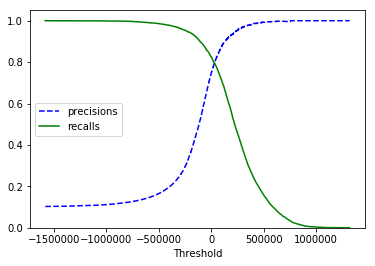

In [20]:
def plot_precision_recall_curve(precisoins, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "--b", label='precisions')
    plt.plot(thresholds, recalls[:-1], "g-", label="recalls")
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1.05])
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

Note that precision is a bit bumpier around 1.0 but recall smoothly decreases.

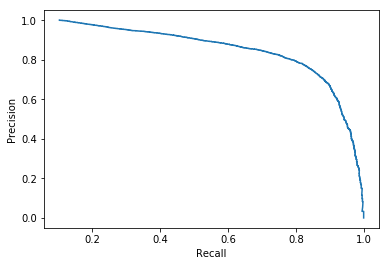

In [21]:
plt.plot(precisions, recalls)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

It seems around 80% recall, precision drops really dramaticly! So in this case probably around 60% recall seems to be a good tradeoff between recall and precision.

In [22]:
# Now we can change the threshold to the one that we
# chose base on the tradeoff we made.
y_train_pred_90 = (y_scores > 70000)

In [23]:
# now let's review the new precision and recall
new_precision = precision_score(y_train_3, y_train_pred_90)
new_recall = recall_score(y_train_3, y_train_pred_90)
print(new_precision, new_recall)

0.843710060252 0.753710650791


Conclusion: The right question to ask about high precision classifiers is, "At what recall"!

### 3. The ROC Curve and ROC AUC
ROC curves are another tool that are being used on binary classifiers. ROC curve plots *true positive rate* (or recall) vursuse *false positive rate* which is 1 - *true negative rate* (specifity). So ROC plots TPR vs 1-TNR or sensitivity vs 1-specificity.

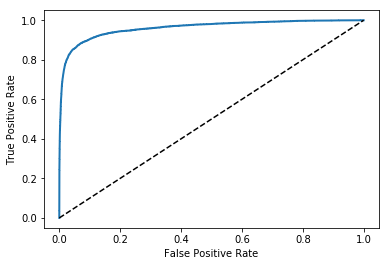

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr , thresholds = roc_curve(y_train_3, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2 , label=label)
    plt.plot([0,1],[0,1],'k--', label='purely random classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

  * A good classifier stays as far as possible from the dotted line.
  * A perfect classifier has ROC AUC = 1.0 and a purely random classifier has ROC AUC = 0.5

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_3, y_scores)

0.96098719451280412

Rule of Thumb: Whenever the positive class is rare or we care more about False positivs than False negatives, we use PR curve, otherwise ROC Curve.

## Random Forest Classifier
Random Forest Classifier has a predict_prob() function isnstead of a decision_function() and it returns onw row per instance and one column per class which represents the probability of that instance belonging to that specific class.

In [26]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probes_forest = cross_val_predict(forest_clf, x_train, y_train_3, cv=3, method="predict_proba")

In [27]:
y_scores_forest = y_probes_forest[:,1] # score = proba of the positive class
fpr_forest, tpr_forest , thresholds_forest = roc_curve(y_train_3, y_scores_forest)


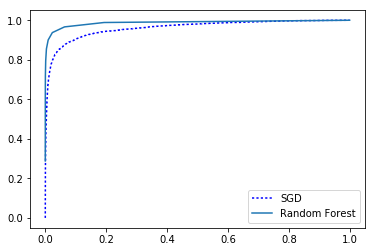

In [28]:
plt.clf()
plt.plot(fpr, tpr, 'b:', label='SGD')
plt.plot(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='lower right')
plt.show()

ROC cureve for Random Forest is better than SGD classifier.So the ROC AUC should be higher too:

In [29]:
roc_auc_score(y_train_3, y_scores_forest)

0.98795571231161583

In [30]:
print(y_scores_forest.shape)

(60000,)


In [31]:
from sklearn import model_selection
from sklearn.metrics import make_scorer, accuracy_score

accuracy_forest =  make_scorer(accuracy_score),
precision_forest = make_scorer(precision_score),
recall_forest = make_scorer(recall_score),
f1_score_forest = make_scorer(f1_score)


kfold = model_selection.KFold(n_splits=3, random_state=42)
model=RandomForestClassifier() 

results = model_selection.cross_val_score(estimator=model,
                                          X=x_train,
                                          y=y_train_3,
                                          cv=kfold,
                                          scoring=make_scorer(precision_score))

In [32]:
print(results)

[ 0.98388097  0.98440312  0.98830049]


# Training Multiclass Classifiers
Let's now try to classfy all the digits! We could use 10 binary classifiers, one for each digit, and pick the highest score among all for images as the final result. this method is called *one vs all*.
on smaller data sets, OVA is preferred to a classifier like SGD, since SGD takes a long time to classify! 

In [33]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([picked_sample])

array([ 3.])

In [34]:
# sklearn here is actually running 10 binay classifers and returns the highest score
picked_sample_score = sgd_clf.decision_function([picked_sample])
picked_sample_score

array([[-574922.4467018 , -178292.02411836, -404366.56415274,
         252848.4549389 , -269302.41763921, -333414.90808479,
        -318624.2440167 , -305795.15995245, -581220.74115462,
        -820632.83081167]])

In [35]:
# it is as easy for random forest classifier , but it automatically classify instances into multiple classes
forest_clf.fit(x_train, y_train)
forest_clf.predict([picked_sample])

array([ 3.])

In [36]:
forest_clf.predict_proba([picked_sample])

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [37]:
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=3)
sgd_conf_mx = confusion_matrix(y_train, y_train_pred)

In [38]:
sgd_conf_mx

array([[5638,    3,   35,   15,    6,  120,   51,    8,   34,   13],
       [   1, 6485,   34,   24,    3,   35,    8,    6,  129,   17],
       [  47,   93, 5203,  211,   37,   57,   59,   55,  151,   45],
       [  42,   38,  164, 5283,    8,  393,   23,   31,   83,   66],
       [  26,   44,   98,   26, 4857,  194,   38,   35,  109,  415],
       [  80,   53,   55,  238,   70, 4525,  113,   13,  193,   81],
       [  71,   37,   94,   18,   37,  147, 5439,   10,   54,   11],
       [  49,   48,   93,   82,   53,   61,    5, 5450,   28,  396],
       [  52,  331,  148,  315,   68,  706,   38,   18, 4035,  140],
       [  38,   51,   42,  106,  192,  341,    4,  224,   71, 4880]])

That's too many numbers, a better way is to visualize the color coded version.

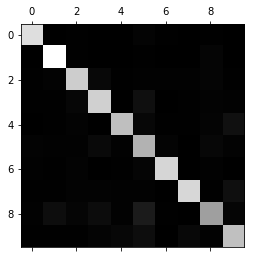

In [39]:
plt.matshow(sgd_conf_mx, cmap=plt.cm.gray)
plt.show()

This Matrix looks good cause most of the images are on the diagonal cells. However in order to get a better understanding of rates, we can devide each value of the cells by the number of images in each class(sum of the rows in one column), so we can see how is the error rate when considering the number of samples.

In [40]:
sum_row = sgd_conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = sgd_conf_mx / sum_row

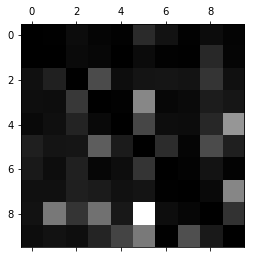

In [41]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

As you can see, classifier has misclassified digits more on 5, 8 and 9. 

# Multilabel Classifiers
Sometimes we would like the classifier to ourput multiple classes. For example in a face-recognizer, we want it to be able to classify all the faces in one image. 

In [42]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train > 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)
knn_clf.predict([picked_sample])

array([[False,  True]], dtype=bool)

In [43]:
# y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
# 'macro' assumes all the labels are equally important. 
# if you want to give each class a weight equal to it's
# support (meaning number of instances in that class, set average parameter to wieighted) 
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Multiout Classifier
Sometimes we not only want to output multilabels, but also each of those can have multipe outputs. For example if we have a noisy image of a digit, we want it not only be able to classify that digit but also outputs the pixel intensities in that image and finally denoise and output a clear image.

In [47]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100,(len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

(1, 784)


/home/aramhamidi/anaconda3/envs/udacity2/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


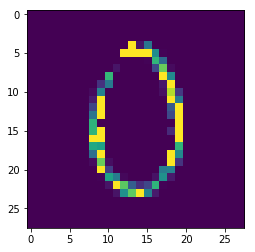

In [70]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict(x_test_mod[252])
print(clean_digit.shape)
plt.imshow(clean_digit.reshape(28,28))
plt.show()

In [65]:
print(x_test_mod[picked_sample])
print(x_test_mod[0].shape)
print(x_test_mod.shape)

[[74 96 75 ..., 80 36 45]
 [74 96 75 ..., 80 36 45]
 [74 96 75 ..., 80 36 45]
 ..., 
 [74 96 75 ..., 80 36 45]
 [74 96 75 ..., 80 36 45]
 [74 96 75 ..., 80 36 45]]
(784,)
(10000, 784)
